In [ ]:
# Random Forest

In [5]:
# Importing required libraries and modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [6]:
# Reading train and test data
train_data = 'data/orange_small_train.data'
test_data = 'data/orange_small_test.data'
df_train = pd.read_csv(train_data, sep = '\t')
df_test = pd.read_csv(test_data, sep = '\t')
y_train = pd.read_csv('data/orange_small_train_churn.labels.txt', header= None).values

In [7]:
# Dropping columns with NaN values
df_train.dropna(axis = 1, inplace = True)

In [8]:
df_train.shape

(50000, 19)

In [9]:
y_train.shape

(50000, 1)

In [10]:
y_train = y_train.reshape(len(y_train),)
y_train.shape

(50000,)

In [11]:
# Selecting the numerical variables and categorical variables with at most 10 categories
preferred_unique_count = 10
fe_unique_columns = list(df_train.select_dtypes(include='number').columns) + list(
    (df_train.select_dtypes(include='object').nunique() < preferred_unique_count).index[
        df_train.select_dtypes(include='object').nunique() < preferred_unique_count])

In [12]:
# Performing one hot encoding
cat = ['Var196', 'Var210', 'Var211', 'Var221', 'Var227']
X_train = df_train[fe_unique_columns]
X_test = df_test[fe_unique_columns]
X_train = pd.get_dummies(X_train, cat)
X_test = pd.get_dummies(X_test, cat)

In [13]:
# Making sure that the test and train data has the same columns
X_test = X_test[X_train.columns]

In [14]:
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.85, stratify= y_train)

In [17]:
#Setting the max_depth and n_estimators
max_depth = 20
n_estimators = 1000

## Strategy 1 - Vanilla Random Forest

- No correction for imbalance

In [18]:
# Set the maximum depth to be max_depth and use 10 estimators
vanilla_forest = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth)

# Fit the model on the training set
vanilla_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=1000)

In [19]:
# Use the trained model to predict on the validation set
predictions = vanilla_forest.predict(X_val)

# Compute two metrics that better represent misclassification of minority classes
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score1
f_score = f1_score(y_val, predictions)
score1 = round(f_score, 2)

# Compute the AUC and assign it to variable auc1
auc_score = roc_auc_score(y_val, predictions)
auc1 = round(auc_score, 2)

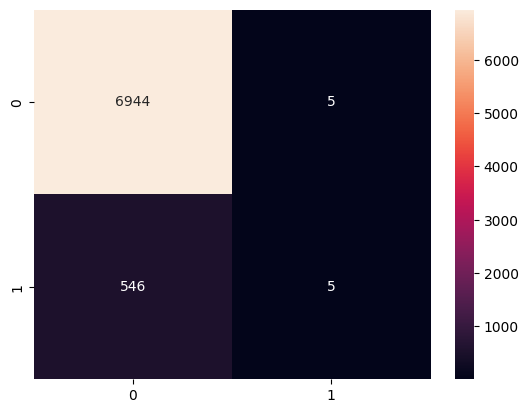

In [20]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

## Strategy 2 - Random Forest with class weighting
- Balancing the class imbalance in each bootstrap

In [21]:
# Use class_weight as balanced_subsample to weigh the class accordingly
rf_with_class_weights = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, class_weight = 'balanced_subsample')

# Fit the model on the training set
rf_with_class_weights.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       n_estimators=1000)

In [22]:
# Use the trained model to predict on the validation set
predictions = rf_with_class_weights.predict(X_val)

# Compute two metrics that better represent misclassification of minority classes
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score2
f_score = f1_score(y_val, predictions)
score2 = round(f_score, 2)

# Compute the AUC and assign it to variable auc2
auc_score = roc_auc_score(y_val, predictions)
auc2 = round(auc_score, 2)

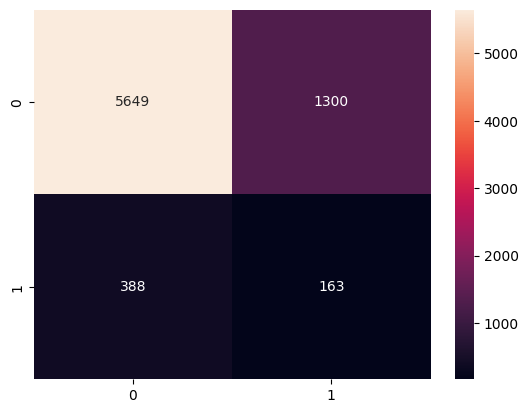

In [23]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

## Strategy 3 - Balanced Random Forest with SMOTE

- Using the **imblearn** `BalancedRandomForestClassifier()`

In [24]:
# Perform upsampling using SMOTE

# Define a SMOTE
sm = SMOTE()

# Use the SMOTE object to upsample the train data
# You may have to use ravel()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [25]:
# Use class_weight as balanced_subsample to weigh the class accordingly
rf_smote = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, class_weight = 'balanced_subsample')

# Fit the Random Forest on upsampled data
rf_smote.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       n_estimators=1000)

In [26]:
# Use the trained model to predict on the validation set
predictions = rf_smote.predict(X_val)

# Compute the F1-score and assign it to variable score3
f_score = f1_score(y_val, predictions)
score3 = round(f_score, 2)

# Compute the AUC and assign it to variable auc3
auc_score = roc_auc_score(y_val, predictions)
auc3 = round(auc_score, 2)

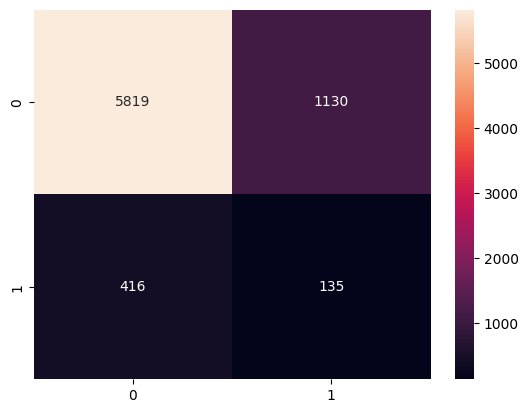

In [27]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

## Strategy 4 - Downsample the data

Using the imblearn RandomUnderSampler().

In [28]:
# Define an RandomUnderSampler instance
rs = RandomUnderSampler(random_state = 2)

# Downsample the train data
# You may have to use ravel()
X_train_res, y_train_res = rs.fit_resample(X_train, y_train)

In [29]:
# Use class_weight as balanced_subsample to weigh the class accordingly
rf_downsampling = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, class_weight = 'balanced_subsample')

# Fit the Random Forest on downsampled data
rf_downsampling.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       n_estimators=1000)

In [30]:
# Use the trained model to predict on the validation set
predictions = rf_downsampling.predict(X_val)

# Compute two metrics that better represent misclassification of minority classes
# i.e `F1 score` and `AUC`

# Compute the F1-score and assign it to variable score4
f_score = f1_score(y_val, predictions)
score4 = round(f_score, 2)

# Compute the AUC and assign it to variable auc4
auc_score = roc_auc_score(y_val, predictions)
auc4 = round(auc_score, 2)

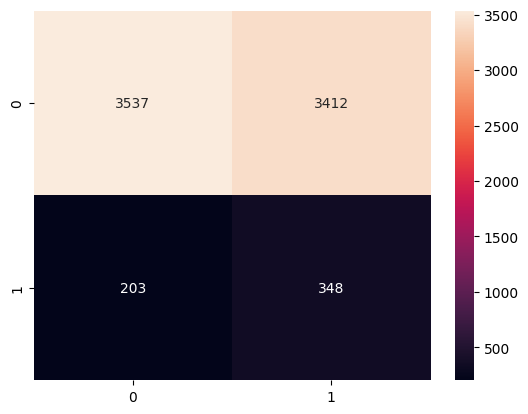

In [31]:
# Plotting confusion matrix
cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm, annot = True, fmt='d')
plt.show()

In [32]:
pt = PrettyTable()
pt.field_names = ["Strategy","F1 Score","AUC score"]
pt.add_row(["Random Forest - No imbalance correction",score1,auc1])
pt.add_row(["Random Forest - balanced_subsamples",score2,auc2])
pt.add_row(["Random Forest - Upsampling",score3,auc3])
pt.add_row(["Random Forest - Downsampling",score4,auc4])
print(pt)

+-----------------------------------------+----------+-----------+
|                 Strategy                | F1 Score | AUC score |
+-----------------------------------------+----------+-----------+
| Random Forest - No imbalance correction |   0.02   |    0.5    |
|   Random Forest - balanced_subsamples   |   0.16   |    0.55   |
|        Random Forest - Upsampling       |   0.15   |    0.54   |
|       Random Forest - Downsampling      |   0.16   |    0.57   |
+-----------------------------------------+----------+-----------+


## Plotting roc auc curve and features importance plot for Random Forest - Downsampling

In [33]:
# Function to plot an ROC curve
def plot_roc(test,logprobs,auc_score, ax):
    fpr, tpr, thresholds = roc_curve(test, logprobs)
    # plt.subplots(1, figsize=(10,10))
    # plt.title('Receiver Operating Characteristic - DecisionTree')
    # plt.plot(fpr, tpr)
    # plt.plot([0, 1], ls="--")
    # plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()

    plt.plot(fpr, tpr, label=f'Logistic Regression (area = {auc_score:.2f})', color = 'b')

    label_kwargs = {}
    label_kwargs['bbox'] = dict(boxstyle='round,pad=0.3', alpha=0.4)

    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    [ax.spines[key].set_visible(False) for key in ax.spines.keys() if key not in ['bottom','left']];
    ax.patch.set_facecolor('None')
    ax.patch.set_alpha(0)
    ax.legend(loc="lower right")

In [34]:
# Function to plot feature importance
# https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

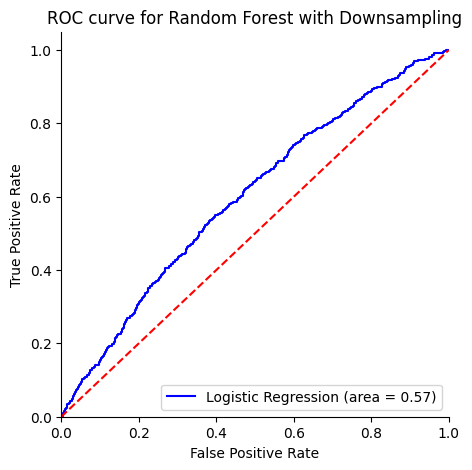

In [35]:
y_probs = rf_downsampling.predict_proba(X_val)[:,1]
fig, ax = plt.subplots(1, figsize = (5, 5))
fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)
plot_roc(y_val,y_probs,auc4, ax)
plt.title('ROC curve for Random Forest with Downsampling')
plt.show()

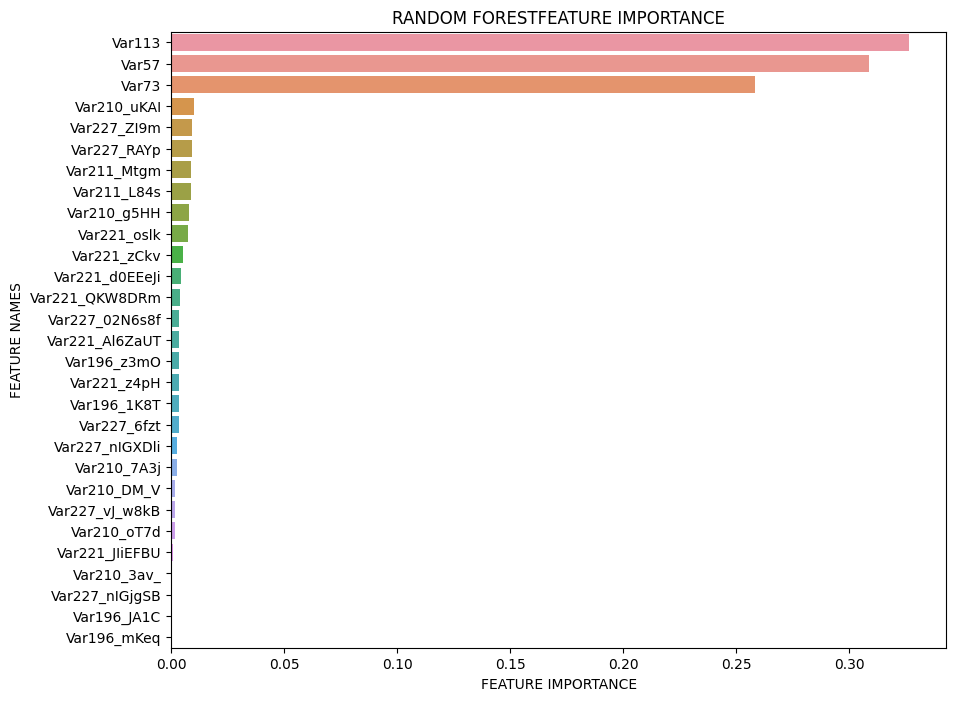

In [36]:
plot_feature_importance(rf_downsampling.feature_importances_,X_train.columns,'RANDOM FOREST')

## GBC

In [4]:
# import libraries
import numpy as np
import pandas as pd


!unzip./ Data / orange_small_test.data.zip
!unzip./ Data / orange_small_train.data.zip

In [5]:
# read the data sets
X_train = pd.read_csv('./Data/orange_small_train.data', sep='\t')
X_test = pd.read_csv('./Data/orange_small_test.data', sep='\t')
y_train_churn = pd.read_csv('./Data/orange_small_train_churn.labels.txt', header=None)
y_train_apt = pd.read_csv('./Data/orange_small_train_appetency.labels', header=None)
y_train_upsell = pd.read_csv('./Data/orange_small_train_upselling.labels', header=None)

In [6]:
print(f"The training data has {X_train.shape[0]} rows and {X_train.shape[1]}")
print(f"since we dont have the test data y values we will be splitting the train data into train and validation ")


The training data has 50000 rows and 230
since we dont have the test data y values we will be splitting the train data into train and validation 


In [64]:
perc_churn_train = np.where(y_train_churn_numeric==-1,0,y_train_churn_numeric).sum()/len(y_train_churn_numeric)*100
perc_churn_val = np.where(y_val_churn_numeric==-1,0,y_val_churn_numeric).sum()/len(y_val_churn_numeric)*100


print("Percentage of Churn in Training Set \t : {:0.2f}%.".format(perc_churn_train))
print("Percentage of Churn in test Set \t : {:0.2f}%.".format(perc_churn_val))

Percentage of Churn in Training Set 	 : 7.05%.
Percentage of Churn in test Set 	 : 7.05%.


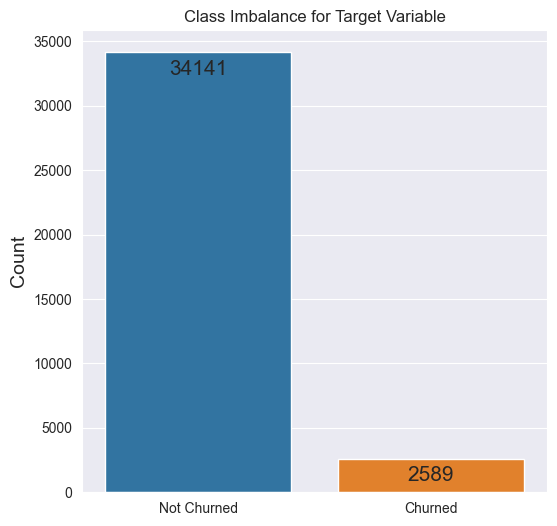

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_imbalance(y_count):
  plt.figure(figsize=(6, 6))
  splot=sns.barplot(x=["Not Churned","Churned"], y = y_count)
  for p in splot.patches:
      splot.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    size=15,
                    xytext = (0, -12),
                    textcoords = 'offset points')
  plt.ylabel("Count", size=14)
  plt.title("Class Imbalance for Target Variable")

plot_imbalance(pd.Series(y_train_churn_numeric.reshape(-1,)).value_counts())

In [67]:
# dropping any column with missing value

# collect minimum no of records to be present value for data
# using data with high percentage of missing records makes bad training set and will induce a high variance in the model predictions
missing_perc = 20
min_count = int(((100 - missing_perc) / 100) * X_train.shape[0] + 1)
print(f" With considering {missing_perc}%  threshold value below which the model would not understand the underlying pattern in th data we would need to have {min_count} no of records in each column")

 With considering 20%  threshold value below which the model would not understand the underlying pattern in th data we would need to have 40001 no of records in each column


### Feature engineering

In [95]:
#drop all missing and retain only numeric variable and preferred amount of uniques in the categorical variable
preferred_uniques = 10
# create a list of numeric values and less than preferred uniques categorical columns
fe_unique_columns = list(X_train.select_dtypes(include='number').columns) + list(
    (X_train.select_dtypes(include='object').nunique() < preferred_uniques).index[
        X_train.select_dtypes(include='object').nunique() < preferred_uniques])
# collect only numeric features
X_train_all_missing_drop_continous = X_train.dropna(axis=1, thresh=min_count).dropna(axis=0).select_dtypes(
    include=['number'])  #.agg(['nunique','count'])
numeric_col_after_drop = X_train_all_missing_drop_continous.columns
# create X_train with categorical variables with less than 10 uniques
X_train_all_missing_dropped_preferred_unique_cat = X_train[fe_unique_columns].dropna(axis=1, thresh=min_count).dropna(
    axis=0)
feature_preferred_columns = list(X_train_all_missing_dropped_preferred_unique_cat.columns)
# creating dummy variables for the data with  categorical variables
X_train_encoded = pd.get_dummies(X_train_all_missing_dropped_preferred_unique_cat, drop_first=True)
X_train_numeric = X_train_all_missing_drop_continous
del X_train_all_missing_drop_continous
# selecting X_test with the appropriate predictors for numeric predictors and selected unique threshold for category inclusion in predictors
X_test_numeric = X_test[numeric_col_after_drop]
X_test_encoded = pd.get_dummies(X_test[feature_preferred_columns], drop_first=True)[X_train_encoded.columns]
y_train_churn_numeric = y_train_churn.values[X_train_numeric.index].reshape(-1,)
y_train_churn_encoded = y_train_churn.values[X_train_encoded.index].reshape(-1,)

In [96]:
# splitting the train and test so there are
from sklearn.model_selection import  train_test_split

X_train_churn_numeric,X_val_churn_numeric,y_train_churn_numeric,y_val_churn_numeric = train_test_split(X_train_numeric,y_train_churn_numeric,test_size=0.2,stratify=y_train_churn_numeric)

X_train_churn_encoded,X_val_churn_encoded,y_train_churn_encoded,y_val_churn_encoded = train_test_split(X_train_encoded,y_train_churn_encoded,test_size=0.2,stratify=y_train_churn_encoded)

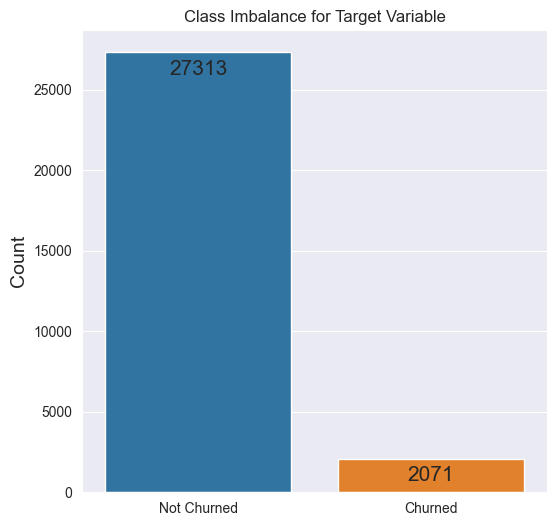

In [97]:
# check for imbalance when only the X_train_encoded index is selected

plot_imbalance(pd.Series(y_train_churn_numeric).value_counts())

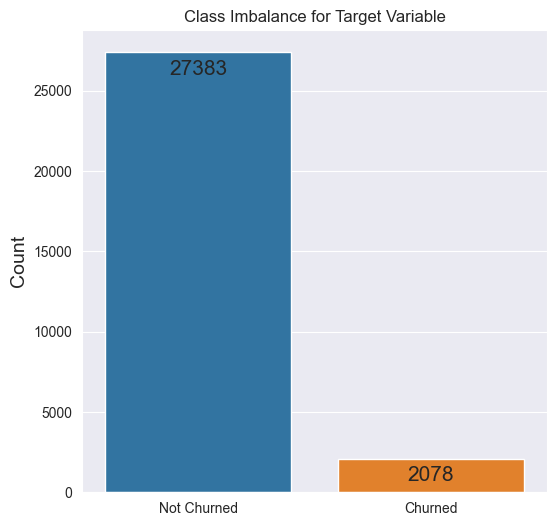

In [98]:
plot_imbalance(pd.Series(y_train_churn_encoded).value_counts())

## Handling class imbalance

In [85]:
from imblearn.over_sampling import SMOTE

In [101]:
sm = SMOTE(random_state=42)
X_train_res_churn_numeric, y_train_res_churn_numeric = sm.fit_resample(X_train_churn_numeric,y_train_churn_numeric)
X_train_res_churn_encoded, y_train_res_churn_encoded = sm.fit_resample(X_train_churn_encoded,y_train_churn_encoded)

Numeric variable data dependant variable churn proportion


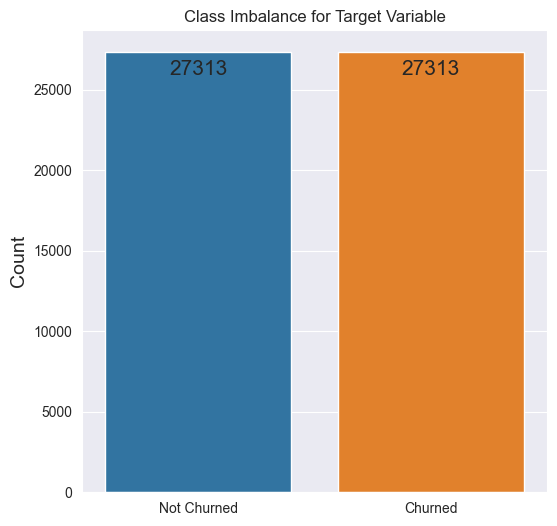

In [103]:
print('Numeric variable data dependant variable churn proportion')
plot_imbalance(pd.Series(y_train_res_churn_numeric).value_counts())

Categorical encoded data dependant variable churn proportion


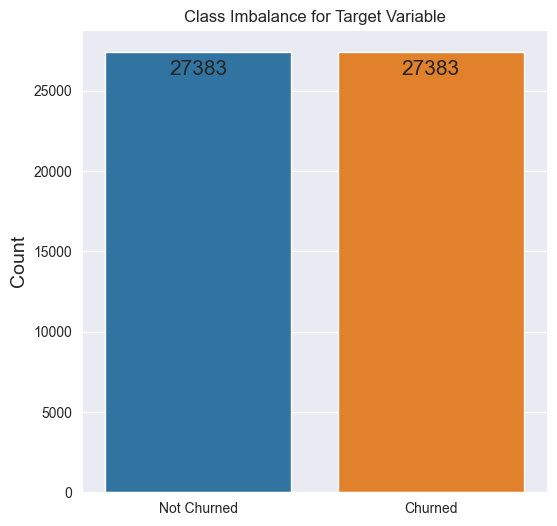

In [102]:
print('Categorical encoded data dependant variable churn proportion')
plot_imbalance(pd.Series(y_train_res_churn_encoded).value_counts())

## Churn model

In [104]:
X_train_churn_numeric.shape,X_val_churn_numeric.shape,y_train_churn_numeric.shape,y_val_churn_numeric.shape

((29384, 38), (7346, 38), (29384,), (7346,))

## Gradient Boosting Classifier

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [109]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators": [5,50],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 1, 10, 30]
}

In [130]:
%%time
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=5,scoring='roc_auc',n_jobs=-1)


CPU times: user 18 µs, sys: 4 µs, total: 22 µs
Wall time: 25.7 µs


In [131]:
%%time
cv_results = cv.fit(X_train_churn_numeric.values,y_train_churn_numeric.ravel())
print("Best: %f using %s for no imbalance correction data is " % (cv_results.best_score_, cv_results.best_params_))

Best: 0.628901 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50} for no imbalance correction data is 
CPU times: user 6.83 s, sys: 291 ms, total: 7.13 s
Wall time: 4min 5s


In [132]:
from sklearn.metrics import f1_score,roc_auc_score

In [137]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,n_estimators=50)
clf.fit(X_train_churn_numeric,y_train_churn_numeric)
predictions_val = clf.predict(X_val_churn_numeric)
predictions_train = clf.predict(X_train_churn_numeric)

train_score1 = f1_score(y_train_churn_numeric,predictions_train).round(3)
train_auc1 = roc_auc_score(y_train_churn_numeric,predictions_train).round(3)

val_score1 = f1_score(y_val_churn_numeric,predictions_val).round(3)
val_auc1 = roc_auc_score(y_val_churn_numeric,predictions_val).round(3)

from prettytable import PrettyTable
pt = PrettyTable()
pt.field_names = ["Strategy","F1 Score","AUC score"]
pt.add_row(["GradientBoosting_numeric_data  - No imbalance correction : train",train_score1,train_auc1])
pt.add_row(["GradientBoosting_numeric_data  - No imbalance correction : val",val_score1,val_auc1])
print(pt)

+------------------------------------------------------------------+----------+-----------+
|                             Strategy                             | F1 Score | AUC score |
+------------------------------------------------------------------+----------+-----------+
| GradientBoosting_numeric_data  - No imbalance correction : train |  0.009   |   0.502   |
|  GradientBoosting_numeric_data  - No imbalance correction : val  |   0.0    |    0.5    |
+------------------------------------------------------------------+----------+-----------+


In [123]:
%%time
# fitting in balanced data

cv_results2 = cv.fit(X_train_res_churn_numeric.values,y_train_res_churn_numeric.ravel())
print("Best: %f using %s imbalance SMOTE upsampling data is " % (cv_results2.best_score_, cv_results2.best_params_))

Best: 0.974213 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50} imbalance SMOTE upsampling data is 
CPU times: user 44.1 s, sys: 487 ms, total: 44.5 s
Wall time: 10min 11s


In [138]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=9,n_estimators=50)
clf.fit(X_train_res_churn_numeric.values,y_train_res_churn_numeric.ravel())

predictions_val = clf.predict(X_val_churn_numeric)
predictions_train = clf.predict(X_train_res_churn_numeric)

train_score2 = f1_score(y_train_res_churn_numeric,predictions_train).round(3)
train_auc2 = roc_auc_score(y_train_res_churn_numeric,predictions_train).round(3)

val_score2 = f1_score(y_val_churn_numeric,predictions_val).round(3)
val_auc2 = roc_auc_score(y_val_churn_numeric,predictions_val).round(3)

pt.add_row(["GradientBoosting_numeric_data  - imbalance correction : train",train_score2,train_auc2])
pt.add_row(["GradientBoosting_numeric_data  - imbalance correction : val",val_score2,val_auc2])
print(pt)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


+------------------------------------------------------------------+----------+-----------+
|                             Strategy                             | F1 Score | AUC score |
+------------------------------------------------------------------+----------+-----------+
| GradientBoosting_numeric_data  - No imbalance correction : train |  0.009   |   0.502   |
|  GradientBoosting_numeric_data  - No imbalance correction : val  |   0.0    |    0.5    |
|  GradientBoosting_numeric_data  - imbalance correction : train   |  0.961   |   0.963   |
|   GradientBoosting_numeric_data  - imbalance correction : val    |  0.004   |   0.501   |
+------------------------------------------------------------------+----------+-----------+


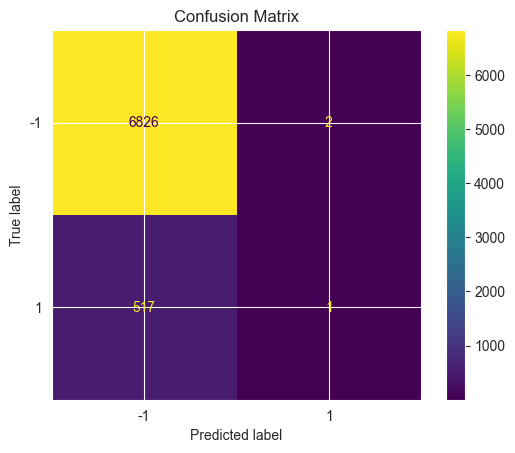

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val_churn_numeric, predictions_val, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cv.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [140]:
cm

array([[6826,    2],
       [ 517,    1]])

# trying out sample weights

In [146]:
sample_weights = np.zeros(len(y_train_res_churn_numeric)).reshape(-1,1)
sample_weights[y_train_res_churn_numeric == -1] = 0.5
sample_weights[y_train_res_churn_numeric == 1] = 9.1

In [147]:
sample_weights.shape

(54626, 1)

In [148]:
cv_results = cv.fit(X_train_res_churn_numeric.values,y_train_res_churn_numeric.ravel(),sample_weight = sample_weights.reshape(-1,))

In [149]:
print("Best: %f using %s" % (cv_results.best_score_, cv_results.best_params_))

Best: 0.972617 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}


In [152]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=9,n_estimators=50)
clf.fit(X_train_res_churn_numeric.values,y_train_res_churn_numeric.ravel(),sample_weight = sample_weights.reshape(-1,))

predictions_val = clf.predict(X_val_churn_numeric)
predictions_train = clf.predict(X_train_res_churn_numeric)

train_score3 = f1_score(y_train_res_churn_numeric,predictions_train).round(3)
train_auc3 = roc_auc_score(y_train_res_churn_numeric,predictions_train).round(3)

val_score3 = f1_score(y_val_churn_numeric,predictions_val).round(3)
val_auc3 = roc_auc_score(y_val_churn_numeric,predictions_val).round(3)

pt.add_row(["GradientBoosting_numeric_data  - imbalance correction weighted: train",train_score3,train_auc3])
pt.add_row(["GradientBoosting_numeric_data  - imbalance correction weighted : val",val_score3,val_auc3])
print(pt)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


+-----------------------------------------------------------------------+----------+-----------+
|                                Strategy                               | F1 Score | AUC score |
+-----------------------------------------------------------------------+----------+-----------+
|    GradientBoosting_numeric_data  - No imbalance correction : train   |  0.009   |   0.502   |
|     GradientBoosting_numeric_data  - No imbalance correction : val    |   0.0    |    0.5    |
|     GradientBoosting_numeric_data  - imbalance correction : train     |  0.961   |   0.963   |
|      GradientBoosting_numeric_data  - imbalance correction : val      |  0.004   |   0.501   |
| GradientBoosting_numeric_data  - imbalance correction weighted: train |  0.819   |    0.78   |
|  GradientBoosting_numeric_data  - imbalance correction weighted : val |  0.149   |   0.556   |
+-----------------------------------------------------------------------+----------+-----------+


In [153]:
# we observe improvement in the validation roc_auc score but the accuracy score is fairly dropped

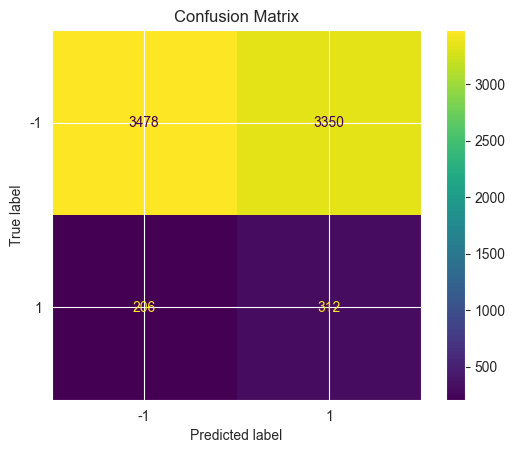

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val_churn_numeric, predictions_val, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cv.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [156]:
cm

array([[3478, 3350],
       [ 206,  312]])

In [157]:
# the drawback here is even the non churn values got classified as churn, this is tradeoff if we want higher accuracy on getting all possible churns; Spending an extra amount to promote retention is better than loosing any and way more expensive to gain new ones

## Gradient Boosting Classifier for encoded

In [158]:
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators": [5,50],
    "max_depth": [1, 3, 5, 7, 9],
    "learning_rate": [0.01, 0.1, 1, 10, 30]
}

In [159]:
%%time
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(gbc,parameters,cv=5,scoring='roc_auc',n_jobs=-1)


CPU times: user 28 µs, sys: 36 µs, total: 64 µs
Wall time: 69.1 µs


In [160]:
%%time
cv_results = cv.fit(X_train_churn_encoded.values,y_train_churn_encoded.ravel())
print("Best: %f using %s for no imbalance correction data is " % (cv_results.best_score_, cv_results.best_params_))

Best: 0.660867 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50} for no imbalance correction data is 
CPU times: user 10.9 s, sys: 348 ms, total: 11.2 s
Wall time: 5min 12s


In [132]:
from sklearn.metrics import f1_score,roc_auc_score

In [161]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,n_estimators=50)
clf.fit(X_train_churn_encoded,y_train_churn_encoded)
predictions_val = clf.predict(X_val_churn_encoded)
predictions_train = clf.predict(X_train_churn_encoded)

train_score1 = f1_score(y_train_churn_encoded,predictions_train).round(3)
train_auc1 = roc_auc_score(y_train_churn_encoded,predictions_train).round(3)

val_score1 = f1_score(y_val_churn_encoded,predictions_val).round(3)
val_auc1 = roc_auc_score(y_val_churn_encoded,predictions_val).round(3)


pt.add_row(["GradientBoosting_encoded_data  - No imbalance correction : train",train_score1,train_auc1])
pt.add_row(["GradientBoosting_encoded_data  - No imbalance correction : val",val_score1,val_auc1])
print(pt)

+-----------------------------------------------------------------------+----------+-----------+
|                                Strategy                               | F1 Score | AUC score |
+-----------------------------------------------------------------------+----------+-----------+
|    GradientBoosting_numeric_data  - No imbalance correction : train   |  0.009   |   0.502   |
|     GradientBoosting_numeric_data  - No imbalance correction : val    |   0.0    |    0.5    |
|     GradientBoosting_numeric_data  - imbalance correction : train     |  0.961   |   0.963   |
|      GradientBoosting_numeric_data  - imbalance correction : val      |  0.004   |   0.501   |
| GradientBoosting_numeric_data  - imbalance correction weighted: train |  0.819   |    0.78   |
|  GradientBoosting_numeric_data  - imbalance correction weighted : val |  0.149   |   0.556   |
|    GradientBoosting_encoded_data  - No imbalance correction : train   |  0.008   |   0.502   |
|     GradientBoosting_encoded

In [162]:
%%time
# fitting in balanced data

cv_results2 = cv.fit(X_train_res_churn_encoded.values,y_train_res_churn_encoded.ravel())
print("Best: %f using %s imbalance SMOTE upsampling data is " % (cv_results2.best_score_, cv_results2.best_params_))

Best: 0.972843 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50} imbalance SMOTE upsampling data is 
CPU times: user 1min 16s, sys: 759 ms, total: 1min 17s
Wall time: 13min 20s


In [163]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=9,n_estimators=50)
clf.fit(X_train_res_churn_encoded.values,y_train_res_churn_encoded.ravel())


predictions_val = clf.predict(X_val_churn_encoded)
predictions_train = clf.predict(X_train_res_churn_encoded)

train_score2 = f1_score(y_train_res_churn_encoded,predictions_train).round(3)
train_auc2 = roc_auc_score(y_train_res_churn_encoded,predictions_train).round(3)

val_score2 = f1_score(y_val_churn_encoded,predictions_val).round(3)
val_auc2 = roc_auc_score(y_val_churn_encoded,predictions_val).round(3)

pt.add_row(["GradientBoosting_encoded_data  - imbalance correction : train",train_score2,train_auc2])
pt.add_row(["GradientBoosting_encoded_data  - imbalance correction : val",val_score2,val_auc2])
print(pt)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


+-----------------------------------------------------------------------+----------+-----------+
|                                Strategy                               | F1 Score | AUC score |
+-----------------------------------------------------------------------+----------+-----------+
|    GradientBoosting_numeric_data  - No imbalance correction : train   |  0.009   |   0.502   |
|     GradientBoosting_numeric_data  - No imbalance correction : val    |   0.0    |    0.5    |
|     GradientBoosting_numeric_data  - imbalance correction : train     |  0.961   |   0.963   |
|      GradientBoosting_numeric_data  - imbalance correction : val      |  0.004   |   0.501   |
| GradientBoosting_numeric_data  - imbalance correction weighted: train |  0.819   |    0.78   |
|  GradientBoosting_numeric_data  - imbalance correction weighted : val |  0.149   |   0.556   |
|    GradientBoosting_encoded_data  - No imbalance correction : train   |  0.008   |   0.502   |
|     GradientBoosting_encoded

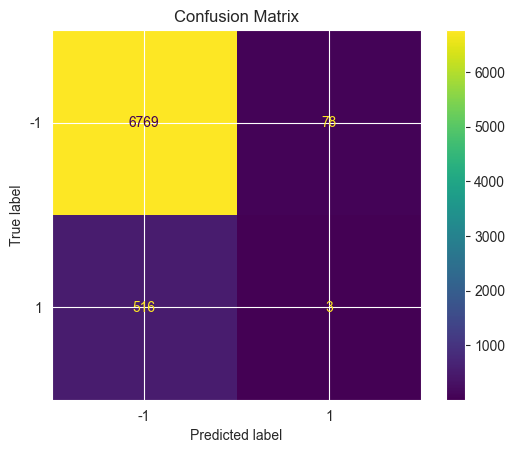

In [164]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val_churn_encoded, predictions_val, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cv.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [165]:
cm

array([[6769,   78],
       [ 516,    3]])

# trying out sample weights

In [166]:
sample_weights = np.zeros(len(y_train_res_churn_encoded)).reshape(-1,1)
sample_weights[y_train_res_churn_encoded == -1] = 0.5
sample_weights[y_train_res_churn_encoded == 1] = 9.1

In [167]:
sample_weights.shape

(54766, 1)

In [148]:
cv_results = cv.fit(X_train_res_churn_encoded.values,y_train_res_churn_encoded.ravel(),sample_weight = sample_weights.reshape(-1,))

In [149]:
print("Best: %f using %s" % (cv_results.best_score_, cv_results.best_params_))

Best: 0.972617 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}


In [168]:
clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=9,n_estimators=50)
clf.fit(X_train_res_churn_encoded.values,y_train_res_churn_encoded.ravel(),sample_weight = sample_weights.reshape(-1,))

predictions_val = clf.predict(X_val_churn_encoded)
predictions_train = clf.predict(X_train_res_churn_encoded)

train_score3 = f1_score(y_train_res_churn_encoded,predictions_train).round(3)
train_auc3 = roc_auc_score(y_train_res_churn_encoded,predictions_train).round(3)

val_score3 = f1_score(y_val_churn_encoded,predictions_val).round(3)
val_auc3 = roc_auc_score(y_val_churn_encoded,predictions_val).round(3)

pt.add_row(["GradientBoosting_encoded_data  - imbalance correction weighted: train",train_score3,train_auc3])
pt.add_row(["GradientBoosting_encoded_data  - imbalance correction weighted : val",val_score3,val_auc3])
print(pt)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


+-----------------------------------------------------------------------+----------+-----------+
|                                Strategy                               | F1 Score | AUC score |
+-----------------------------------------------------------------------+----------+-----------+
|    GradientBoosting_numeric_data  - No imbalance correction : train   |  0.009   |   0.502   |
|     GradientBoosting_numeric_data  - No imbalance correction : val    |   0.0    |    0.5    |
|     GradientBoosting_numeric_data  - imbalance correction : train     |  0.961   |   0.963   |
|      GradientBoosting_numeric_data  - imbalance correction : val      |  0.004   |   0.501   |
| GradientBoosting_numeric_data  - imbalance correction weighted: train |  0.819   |    0.78   |
|  GradientBoosting_numeric_data  - imbalance correction weighted : val |  0.149   |   0.556   |
|    GradientBoosting_encoded_data  - No imbalance correction : train   |  0.008   |   0.502   |
|     GradientBoosting_encoded

In [153]:
# we observe improvement in the validation roc_auc score but the accuracy score is fairly dropped

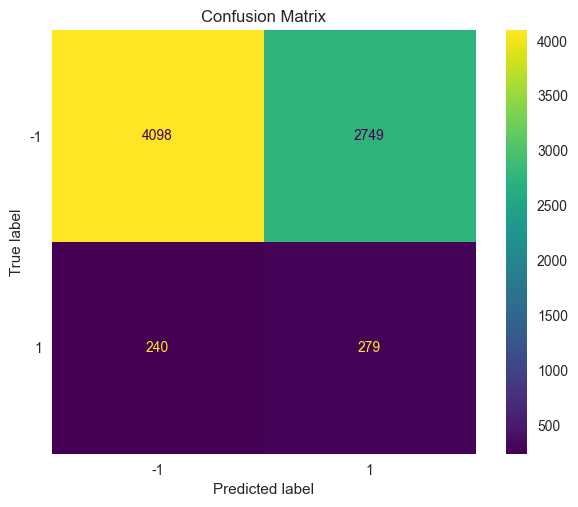

In [182]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_val_churn_encoded, predictions_val, labels=cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cv.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [183]:
cm

array([[4098, 2749],
       [ 240,  279]])

In [175]:
from sklearn.metrics import roc_curve

pred_prob1 = clf.predict_proba(X_val_churn_encoded)
fpr1, tpr1, thresh1 = roc_curve(y_val_churn_encoded, pred_prob1[:,1], pos_label=1)

/Users/slackroo/Data_science/UNIV_ai/venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [179]:
# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_val_churn_encoded))]
p_fpr, p_tpr, _ = roc_curve(y_val_churn_encoded, random_probs, pos_label=1)

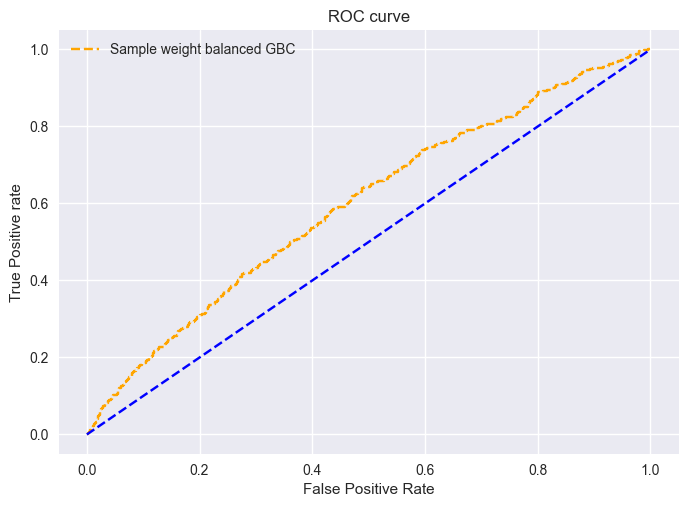

In [181]:
plt.style.use('seaborn')

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Sample weight balanced GBC')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve for gradoent')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();